# SuperKEKB Strong Strong Beam Simulation

The following notebook goes through the following:
- Loads a simplified lattice from MADX to XSuite
- TODO: Add Soleoid
- TODO: Optics Corrections
- Twiss the lattice
- Vertial Emittance tuning with Sextupole offsets
- TODO: Offsets to all elements
- Optics comparison with and without offsets
- TODO: Optics Corrections post offsets
- Strong-Strong Beam simulation

## Simulation Initialisation

### Python Setup

In [ ]:
import sys

import xobjects as xo
import xtrack as xt
import xfields as xf
import xpart as xp

from xtrack.slicing import Teapot, Strategy

from cpymad.madx import Madx

import numpy as np
import scipy.constants as cst
import matplotlib.pyplot as plt

from tqdm import tqdm

### User Variables

In [ ]:
########################################
# Simulation Settings
########################################
n_turns             = int(1E2)
n_macroparticles    = int(1E5)
n_slices            = int(101)

allowed_emit_error  = 50 # [%]
iteration_limit     = 250

########################################
# File Paths
########################################
ler_path            = "/Users/jack/Desktop/*Thesis/Analysis/superkekb/no_sol/sler_1707_80_1_nosol_simple.seq"
her_path            = "/Users/jack/Desktop/*Thesis/Analysis/superkekb/no_sol/sher_5781_60_1_nosol_simple.seq"

########################################
# Computation Mode
########################################
context = xo.ContextCpu(omp_num_threads='auto')

### Machine Parameters

Current Paramters are Pre LS1 Parameters, provided in a table from G. Broggi

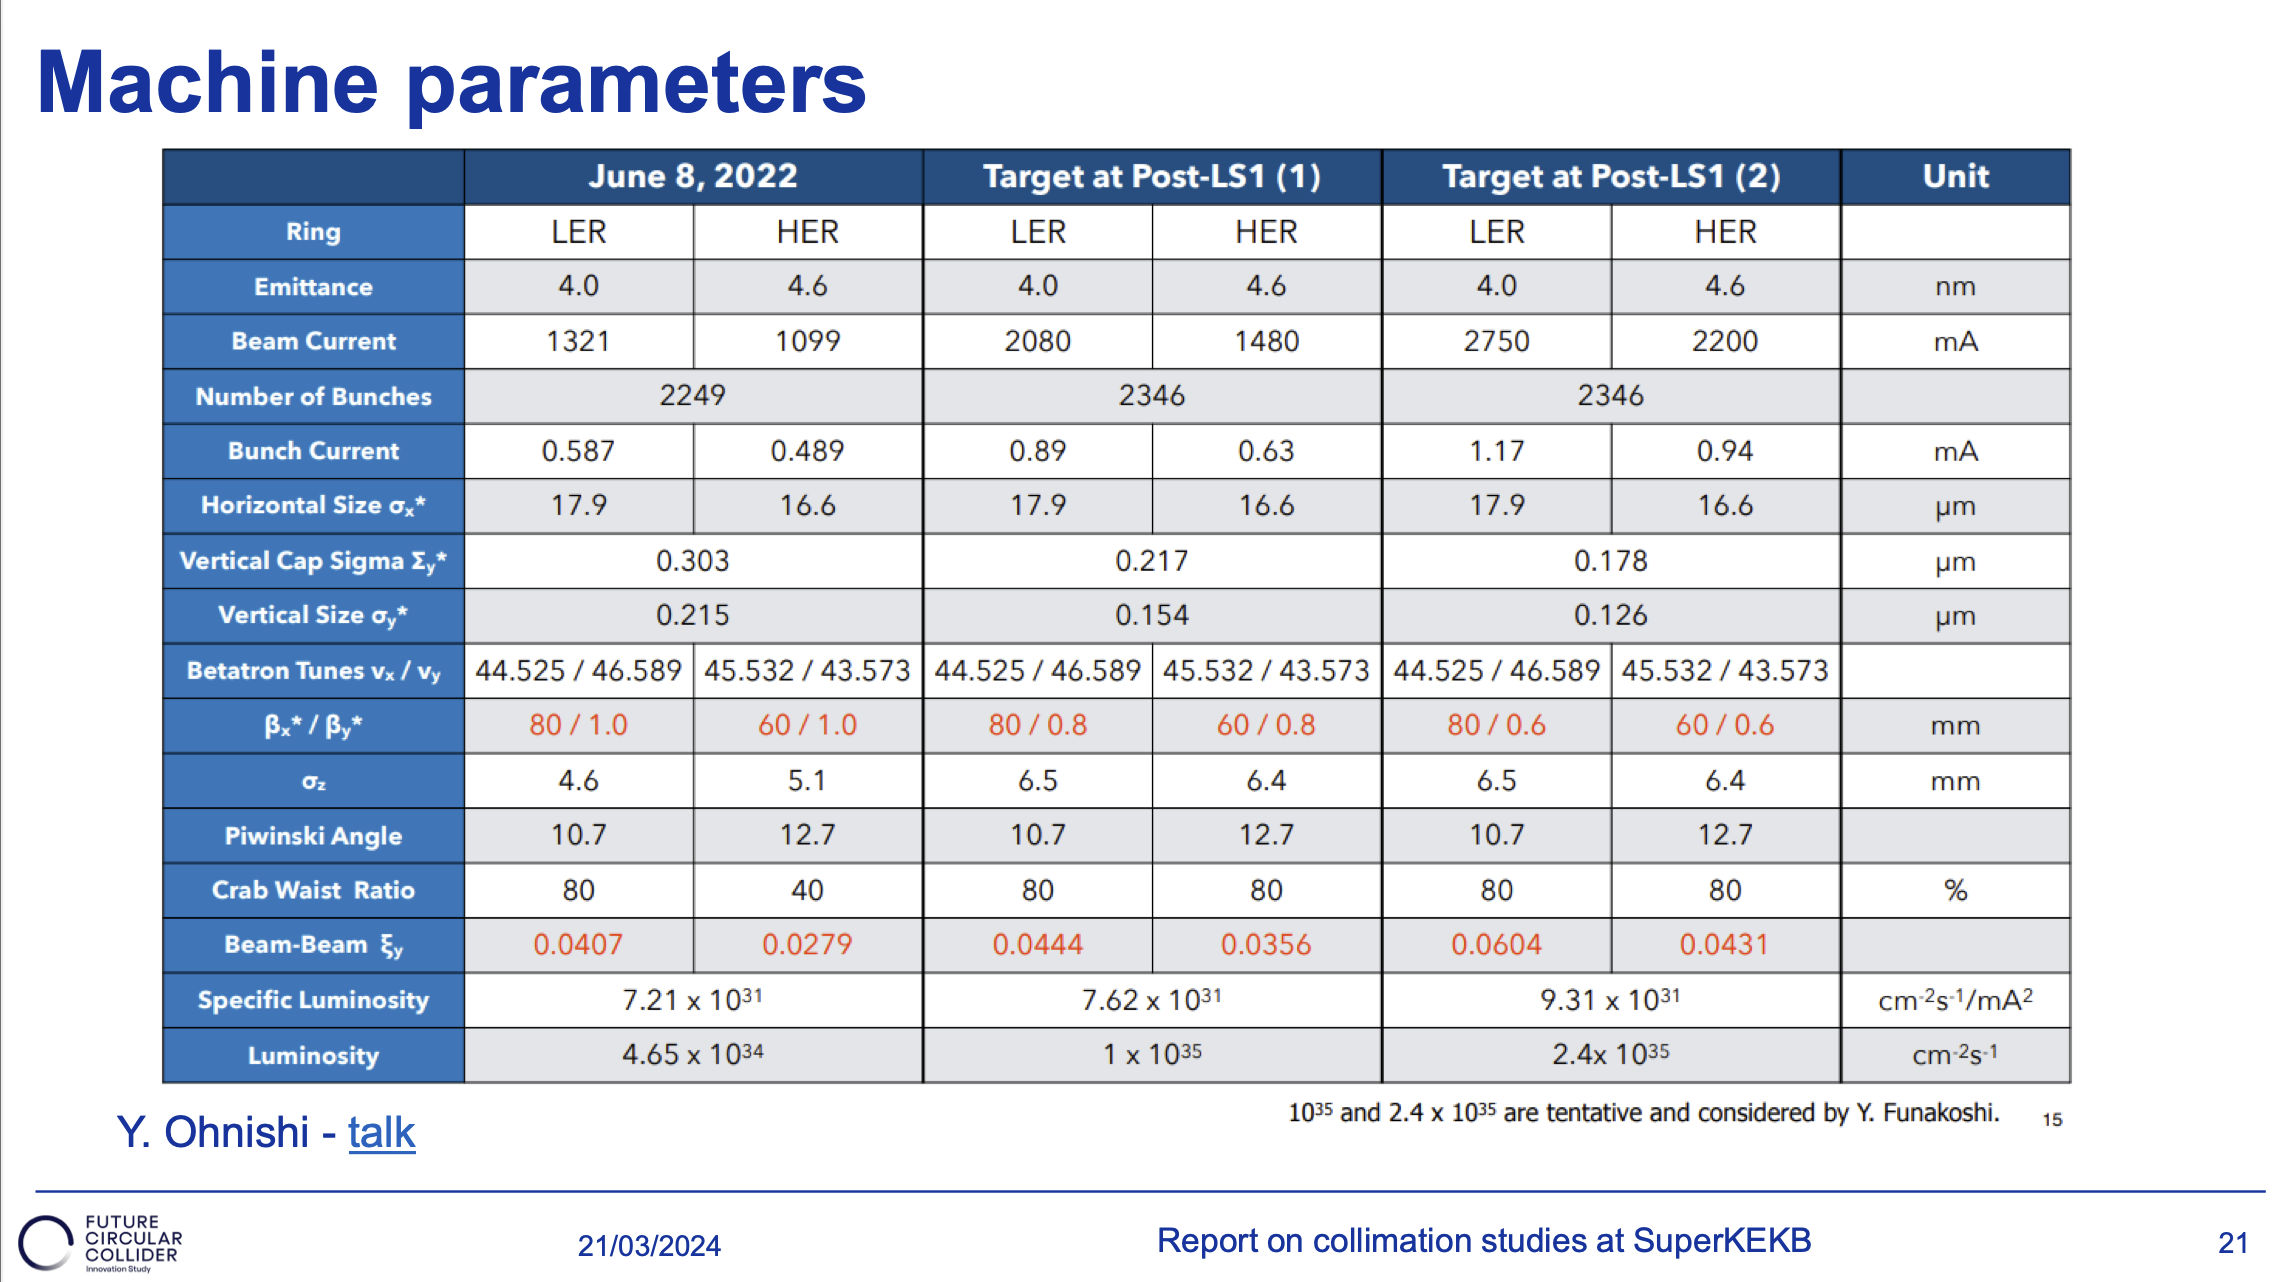

In [ ]:
########################################
# HER Parameters
########################################
her_params = {
    'energy':           7.007,
    'p0c':              7.007E9,
    'bunch_intensity':  3.07E10,
    'n_bunches':        2249,
    'beta_x':           60E-3,
    'beta_y':           1.0E-3,
    'physemit_x':       4.59E-9,
    'physemit_y':       4.62E-11,
    'Qx':               45.532,
    'Qy':               43.573,
    'sigma_delta':      1.00E-3,
    'sigma_z':          5.10E-3,
    'phi':              41.5E-3,
    'circumference':    3016.315,
}

########################################
# LER Parameters
########################################
ler_params = {
    'energy':           4.00,
    'p0c':              4.0E9,
    'bunch_intensity':  3.69E10,
    'n_bunches':        2249,
    'beta_x':           80E-3,
    'beta_y':           1.0E-3,
    'physemit_x':       4.01E-9,
    'physemit_y':       4.62E-11,
    'Qx':               44.525,
    'Qy':               46.589,
    'sigma_delta':      1.00E-3,
    'sigma_z':          4.60E-3,
    'phi':              -41.5E-3,
    'circumference':    3016.315,
}

########################################
# Constants
########################################
mass0               = xp.ELECTRON_MASS_EV

## Load Rings

### Load LER

In [ ]:
mad = Madx(stdout = sys.stdout)
mad.input(
    f"""
        SET, FORMAT="19.15f";
        !option, echo;
        option, update_from_parent=true; // new option in mad-x as of 2/2019

        BEAM, PARTICLE=POSITRON, ENERGY={ler_params['energy']};

        CALL, FILE="{ler_path}";

        USE, SEQUENCE=ASC;
        
        SXT_ON = 1;
        RF_ON =1;
            
        USE,SEQUENCE=ASC;
            TWISS;

    """
)
ler = xt.Line.from_madx_sequence(
        mad.sequence['ASC'],
        allow_thick = True,
        deferred_expressions = True,
    )

### Load HER

In [ ]:
mad = Madx(stdout = sys.stdout)
mad.input(
    f"""
        SET, FORMAT="19.15f";
        !option, echo;
        option, update_from_parent=true; // new option in mad-x as of 2/2019

        BEAM, PARTICLE=POSITRON, ENERGY={her_params['energy']};

        CALL, FILE="{her_path}";

        USE, SEQUENCE=ASCE;
        
        SXT_ON = 1;
        RF_ON =1;
            
        USE,SEQUENCE=ASCE;
            TWISS;

    """
)
her = xt.Line.from_madx_sequence(
        mad.sequence['ASCE'],
        allow_thick=True,
        deferred_expressions=True,
    )

### Pre Sliced Component Tables

In [ ]:
ler_table = ler.get_table()
her_table = her.get_table()

### Slicing

In [ ]:
slicing_strategies = [
    Strategy(slicing=Teapot(1)),
    Strategy(slicing=Teapot(4), element_type=xt.Bend),
    Strategy(slicing=Teapot(5), element_type=xt.Quadrupole),
    Strategy(slicing=Teapot(4), element_type=xt.Sextupole),
]

In [ ]:
ler.discard_tracker()
ler.slice_thick_elements(slicing_strategies)

her.discard_tracker()
her.slice_thick_elements(slicing_strategies)

### Build Reference Particles

In [ ]:
ler_ref_particle = xp.Particles(
    mass0   = xp.ELECTRON_MASS_EV,
    q0      = 1,
    p0c     = ler_params['p0c']
    )
ler.particle_ref = ler_ref_particle

her_ref_particle = xp.Particles(
    mass0   = xp.ELECTRON_MASS_EV,
    q0      = -1,
    p0c     = her_params['p0c']
    )
her.particle_ref = her_ref_particle

In [ ]:
ler.build_tracker()
ler.config.XTRACK_USE_EXACT_DRIFTS = True

her.build_tracker()
her.config.XTRACK_USE_EXACT_DRIFTS = True

### Correct RF

In [ ]:
ler_cavities = ler_table.rows[ler_table.element_type=='Cavity']

for cavity in ler_cavities.name:
    ler.element_refs[cavity].lag = 180

In [ ]:
her_cavities = her_table.rows[her_table.element_type=='Cavity']

for cavity in her_cavities.name:
    her.element_refs[cavity].lag = 180

## Twiss

### Twiss (no radiation, no beam-beam)

In [ ]:
ler_tw_4d = ler.twiss(eneloss_and_damping=False, method="4d")
print(f"LER Tunes: {(ler_tw_4d.qx, ler_tw_4d.qy)}")

her_tw_4d = her.twiss(eneloss_and_damping=False, method="4d")
print(f"HER Tunes: {(her_tw_4d.qx, her_tw_4d.qy)}")

### Configure Radiation

In [ ]:
ler.configure_radiation(model='mean')
ler.compensate_radiation_energy_loss()

her.configure_radiation(model='mean')
her.compensate_radiation_energy_loss()

### Twiss (radiation, no beam-beam)

In [ ]:
ler_tw_rad = ler.twiss(eneloss_and_damping=True, method="6d")
print(f"LER Emittances: {(ler_tw_rad['eq_gemitt_x'], ler_tw_rad['eq_gemitt_y'])}")

her_tw_rad = her.twiss(eneloss_and_damping=True, method="6d")
print(f"HER Emittances: {(her_tw_rad['eq_gemitt_x'], her_tw_rad['eq_gemitt_y'])}")

In [ ]:
print(f"Target LER Betas: " + str((ler_params['beta_x'], ler_params['beta_y'])))
print(f"Twiss LER Betas: " + str((min(ler_tw_rad['betx']), min(ler_tw_rad['bety']))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1_twin = ax1.twinx()
ax2_twin = ax2.twinx()

ax1.plot(ler_tw_rad['s'], ler_tw_rad['betx'], c='b', label='Beta x')
ax1.set_xlabel('s [m]')
ax1.set_ylabel('Beta_x', c='b')
ax1.tick_params(axis='y', labelcolor='g')

ax1_twin.plot(ler_tw_rad['s'], ler_tw_rad['bety'], c='orange', label='Beta y')
ax1_twin.set_ylabel('Beta y', color='orange')
ax1_twin.tick_params(axis='y', labelcolor='orange')

ax2.plot(ler_tw_rad['s'], ler_tw_rad['dx'], c='b', label='Dx')
ax2.set_xlabel('s [m]')
ax2.set_ylabel('Dx', c='b')
ax2.tick_params(axis='y', labelcolor='b')

ax2_twin.plot(ler_tw_rad['s'], ler_tw_rad['dy'], c='orange', label='Dy')
ax2_twin.set_ylabel('Dy', color='orange')
ax2_twin.tick_params(axis='y', labelcolor='orange')

fig.suptitle('LER Twiss Parameters')
fig.tight_layout()

plt.show()


In [ ]:
print(f"Target LER Betas: " + str((her_params['beta_x'], her_params['beta_y'])))
print(f"Twiss LER Betas: " + str((min(her_tw_rad['betx']), min(her_tw_rad['bety']))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1_twin = ax1.twinx()
ax2_twin = ax2.twinx()

ax1.plot(her_tw_rad['s'], her_tw_rad['betx'], c='b', label='Beta x')
ax1.set_xlabel('s [m]')
ax1.set_ylabel('Beta_x', c='b')
ax1.tick_params(axis='y', labelcolor='g')

ax1_twin.plot(her_tw_rad['s'], her_tw_rad['bety'], c='orange', label='Beta y')
ax1_twin.set_ylabel('Beta y', color='orange')
ax1_twin.tick_params(axis='y', labelcolor='orange')

ax2.plot(her_tw_rad['s'], her_tw_rad['dx'], c='b', label='Dx')
ax2.set_xlabel('s [m]')
ax2.set_ylabel('Dx', c='b')
ax2.tick_params(axis='y', labelcolor='b')

ax2_twin.plot(her_tw_rad['s'], her_tw_rad['dy'], c='orange', label='Dy')
ax2_twin.set_ylabel('Dy', color='orange')
ax2_twin.tick_params(axis='y', labelcolor='orange')

fig.suptitle('HER Twiss Parameters')
fig.tight_layout()

plt.show()


## Solenoid

In [ ]:
# TODO all of this

## Lattice Corrections

In [ ]:
# TODO all of this

## Vertical Emittance Tuning

### Add WS Beam-beam

In [ ]:
ler_ws_slicer = xf.TempSlicer(n_slices=n_slices, sigma_z=her_params['sigma_z'], mode="shatilov")

her_sigma_x = np.sqrt(her_params['beta_x'] * her_params['physemit_x'])
her_sigma_y = np.sqrt(her_params['beta_y'] * her_params['physemit_y'])
her_sigma_px = np.sqrt(her_params['physemit_x'] / her_params['beta_x'])
her_sigma_py = np.sqrt(her_params['physemit_y'] / her_params['beta_y'])

ler_ws_bb = xf.BeamBeamBiGaussian3D(
    config_for_update   = None,
    other_beam_q0       = -1,
    phi                 = ler_params['phi'], # half-crossing angle in radians
    alpha               = 0, # crossing plane
    # decide between round or elliptical kick formula
    min_sigma_diff      = 1e-28,
    # slice intensity [num. real particles] n_slices inferred from length of this
    slices_other_beam_num_particles = ler_ws_slicer.bin_weights * her_params['bunch_intensity'],
    # unboosted strong beam moments
    slices_other_beam_zeta_center = ler_ws_slicer.bin_centers,
    slices_other_beam_Sigma_11    = n_slices*[her_sigma_x**2], # Beam sizes for the other beam, assuming the same is approximation
    slices_other_beam_Sigma_22    = n_slices*[her_sigma_px**2],
    slices_other_beam_Sigma_33    = n_slices*[her_sigma_y**2],
    slices_other_beam_Sigma_44    = n_slices*[her_sigma_py**2],
    # only if BS on
    slices_other_beam_zeta_bin_width_star_beamstrahlung = ler_ws_slicer.bin_widths_beamstrahlung / np.cos(ler_params['phi']),  # boosted dz
    # has to be set
    slices_other_beam_Sigma_12  = n_slices*[0],
    slices_other_beam_Sigma_34  = n_slices*[0],
    compt_x_min                 = 1E-4,
    flag_luminosity             = True,
)

ler.discard_tracker()

ler.insert_element(
    index   = 'ip.2',
    element = ler_ws_bb,
    name    = f'ler_ws_bb'
)

In [ ]:
her_ws_slicer = xf.TempSlicer(n_slices=n_slices, sigma_z=ler_params['sigma_z'], mode="shatilov")

ler_sigma_x     = np.sqrt(ler_params['beta_x'] * ler_params['physemit_x'])
ler_sigma_y     = np.sqrt(ler_params['beta_y'] * ler_params['physemit_y'])
ler_sigma_px    = np.sqrt(ler_params['physemit_x'] / ler_params['beta_x'])
ler_sigma_py    = np.sqrt(ler_params['physemit_y'] / ler_params['beta_y'])

her_ws_bb = xf.BeamBeamBiGaussian3D(
    config_for_update   = None,
    other_beam_q0       = 1,
    phi                 = her_params['phi'], # half-crossing angle in radians
    alpha               = 0, # crossing plane
    # decide between round or elliptical kick formula
    min_sigma_diff      = 1e-28,
    # slice intensity [num. real particles] n_slices inferred from length of this
    slices_other_beam_num_particles = her_ws_slicer.bin_weights * ler_params['bunch_intensity'],
    # unboosted strong beam moments
    slices_other_beam_zeta_center = her_ws_slicer.bin_centers,
    slices_other_beam_Sigma_11    = n_slices*[ler_sigma_x**2], # Beam sizes for the other beam, assuming the same is approximation
    slices_other_beam_Sigma_22    = n_slices*[ler_sigma_px**2],
    slices_other_beam_Sigma_33    = n_slices*[ler_sigma_y**2],
    slices_other_beam_Sigma_44    = n_slices*[ler_sigma_py**2],
    # only if BS on
    slices_other_beam_zeta_bin_width_star_beamstrahlung = her_ws_slicer.bin_widths_beamstrahlung / np.cos(her_params['phi']),  # boosted dz
    # has to be set
    slices_other_beam_Sigma_12  = n_slices*[0],
    slices_other_beam_Sigma_34  = n_slices*[0],
    compt_x_min                 = 1E-4,
    flag_luminosity             = True,
)

her.discard_tracker()

her.insert_element(
    index   = 'ip.2',
    element = her_ws_bb,
    name    = f'her_ws_bb'
)

### Twiss (radiation, WS beam-beam)

In [ ]:
ler_tw_ws = ler.twiss(eneloss_and_damping=True, method="6d")
print(f"LER Emittances: {(ler_tw_rad['eq_gemitt_x'], ler_tw_rad['eq_gemitt_y'])}")

her_tw_ws = her.twiss(eneloss_and_damping=True, method="6d")
print(f"HER Emittances: {(her_tw_rad['eq_gemitt_x'], her_tw_rad['eq_gemitt_y'])}")

### Scan offset to see emittance

In [ ]:
ler_sextupoles = ler_table.rows[ler_table.element_type=='Sextupole']
her_sextupoles = her_table.rows[her_table.element_type=='Sextupole']

In [ ]:
def reset_sextupoles():
    for sextupole in ler_sextupoles.name:
        ler.element_refs[sextupole].shift_x     = 0
        ler.element_refs[sextupole].shift_y     = 0
        ler.element_refs[sextupole].rot_s_rad   = 0
    for sextupole in her_sextupoles.name:
        her.element_refs[sextupole].shift_x     = 0
        her.element_refs[sextupole].shift_y     = 0
        her.element_refs[sextupole].rot_s_rad   = 0

In [ ]:
offset_repeats      = 10
offsets             = np.logspace(-5, -3, 21)

In [ ]:
ler_ln_emit_y_means = []
ler_ln_emit_y_stds  = []
her_ln_emit_y_means = []
her_ln_emit_y_stds  = []

for offset in tqdm(offsets):
    ler_offset_ln_emit_ys = []
    her_offset_ln_emit_ys = []
    for i in range(offset_repeats):
        reset_sextupoles()
        for sextupole in ler_sextupoles.name:
            ler.element_refs[sextupole].shift_y = np.random.normal(0, offset)
        for sextupole in her_sextupoles.name:
            her.element_refs[sextupole].shift_y = np.random.normal(0, offset)

        try:
            ler_tw_offset = ler.twiss(eneloss_and_damping=True, method="6d")
            ler_offset_ln_emit_ys.append(np.log(ler_tw_offset['eq_gemitt_y']))
        except:
            ler_offset_ln_emit_ys.append(np.nan)

        try:
            her_tw_offset = ler.twiss(eneloss_and_damping=True, method="6d")
            her_offset_ln_emit_ys.append(np.log(her_tw_offset['eq_gemitt_y']))
        except:
            her_offset_ln_emit_ys.append(np.nan)

    ler_ln_emit_y_means.append(np.nanmean(ler_offset_ln_emit_ys))
    ler_ln_emit_y_stds.append(np.nanstd(ler_offset_ln_emit_ys))

    her_ln_emit_y_means.append(np.nanmean(her_offset_ln_emit_ys))
    her_ln_emit_y_stds.append(np.nanstd(her_offset_ln_emit_ys))

ler_ln_emit_y_means = np.array(ler_ln_emit_y_means)
ler_ln_emit_y_stds  = np.array(ler_ln_emit_y_stds)
her_ln_emit_y_means = np.array(her_ln_emit_y_means)
her_ln_emit_y_stds  = np.array(her_ln_emit_y_stds)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.errorbar(offsets, ler_ln_emit_y_means, yerr=ler_ln_emit_y_stds, fmt='o')
ax1.hlines(np.log(ler_tw_rad['eq_gemitt_y']), offsets[0], offsets[-1], linestyles='dashed', colors='r', label='No Offset No BB')
ax1.hlines(np.log(ler_tw_ws['eq_gemitt_y']), offsets[0], offsets[-1], linestyles='dashed', colors='g', label='No Offset, with BB')
ax1.hlines(np.log(ler_params['physemit_y']), offsets[0], offsets[-1], linestyles='dashed', colors='b', label='Target Physical')
ax1.set_xscale('log')
ax1.set_title('LER')
ax1.set_xlabel('Shift in Sextupole (m)')
ax1.set_ylabel('Natural Log of Emittance')
ax1.set_ylim(-29, -20)

ax2.errorbar(offsets, her_ln_emit_y_means, yerr=her_ln_emit_y_stds, fmt='o')
ax2.hlines(np.log(her_tw_rad['eq_gemitt_y']), offsets[0], offsets[-1], linestyles='dashed', colors='r', label='No Offset No BB')
ax2.hlines(np.log(her_tw_ws['eq_gemitt_y']), offsets[0], offsets[-1], linestyles='dashed', colors='g', label='No Offset, with BB')
ax2.hlines(np.log(her_params['physemit_y']), offsets[0], offsets[-1], linestyles='dashed', colors='b', label='Target Physical')
ax2.set_xscale('log')
ax2.set_title('HER')
ax2.set_xlabel('Shift in Sextupole (m)')
ax2.set_ylabel('Natural Log of Emittance')
ax2.set_ylim(-29, -20)

plt.suptitle("SuperKEKB Sextupole Offset Scan with WS BB")
plt.legend()
plt.tight_layout()
plt.show()

### Choose offset to optimise across both

In [ ]:
ler_diff = np.log(ler_params['physemit_y']) - ler_ln_emit_y_means
her_diff = np.log(her_params['physemit_y']) - her_ln_emit_y_means
mult_diff = ler_diff * her_diff
mult_err = np.sqrt((ler_ln_emit_y_stds / ler_ln_emit_y_means)**2 + (her_ln_emit_y_stds / her_ln_emit_y_means)**2) * mult_diff

optimum_offset = offsets[np.argmin(mult_diff)]

plt.errorbar(offsets, mult_diff, yerr=mult_err, fmt='o')
plt.axvline(optimum_offset, c='r')
plt.xscale('log')
plt.xlabel('Shift in Sextupole (m)')
plt.ylabel('Emittance Discrepancy')
plt.show()

### Repeat Process for narrower and narrower offsets

In [ ]:
offset_repeats      = 20
offsets             = np.logspace(
    np.log10(optimum_offset) - 0.1,
    np.log10(optimum_offset) + 0.1,
    21
)

In [ ]:
ler_ln_emit_y_means = []
ler_ln_emit_y_stds  = []
her_ln_emit_y_means = []
her_ln_emit_y_stds  = []

for offset in tqdm(offsets):
    ler_offset_ln_emit_ys = []
    her_offset_ln_emit_ys = []
    for i in range(offset_repeats):
        reset_sextupoles()
        for sextupole in ler_sextupoles.name:
            ler.element_refs[sextupole].shift_y = np.random.normal(0, offset)
        for sextupole in her_sextupoles.name:
            her.element_refs[sextupole].shift_y = np.random.normal(0, offset)

        try:
            ler_tw_offset = ler.twiss(eneloss_and_damping=True, method="6d")
            ler_offset_ln_emit_ys.append(np.log(ler_tw_offset['eq_gemitt_y']))
        except:
            ler_offset_ln_emit_ys.append(np.nan)

        try:
            her_tw_offset = ler.twiss(eneloss_and_damping=True, method="6d")
            her_offset_ln_emit_ys.append(np.log(her_tw_offset['eq_gemitt_y']))
        except:
            her_offset_ln_emit_ys.append(np.nan)

    ler_ln_emit_y_means.append(np.nanmean(ler_offset_ln_emit_ys))
    ler_ln_emit_y_stds.append(np.nanstd(ler_offset_ln_emit_ys))

    her_ln_emit_y_means.append(np.nanmean(her_offset_ln_emit_ys))
    her_ln_emit_y_stds.append(np.nanstd(her_offset_ln_emit_ys))

ler_ln_emit_y_means = np.array(ler_ln_emit_y_means)
ler_ln_emit_y_stds  = np.array(ler_ln_emit_y_stds)
her_ln_emit_y_means = np.array(her_ln_emit_y_means)
her_ln_emit_y_stds  = np.array(her_ln_emit_y_stds)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.errorbar(offsets, ler_ln_emit_y_means, yerr=ler_ln_emit_y_stds, fmt='o')
ax1.hlines(np.log(ler_tw_rad['eq_gemitt_y']), offsets[0], offsets[-1], linestyles='dashed', colors='r', label='No Offset No BB')
ax1.hlines(np.log(ler_tw_ws['eq_gemitt_y']), offsets[0], offsets[-1], linestyles='dashed', colors='g', label='No Offset, with BB')
ax1.hlines(np.log(ler_params['physemit_y']), offsets[0], offsets[-1], linestyles='dashed', colors='b', label='Target Physical')
ax1.set_xscale('log')
ax1.set_title('LER')
ax1.set_xlabel('Shift in Sextupole (m)')
ax1.set_ylabel('Natural Log of Emittance')
ax1.set_ylim(-26, -22)

ax2.errorbar(offsets, her_ln_emit_y_means, yerr=her_ln_emit_y_stds, fmt='o')
ax2.hlines(np.log(her_tw_rad['eq_gemitt_y']), offsets[0], offsets[-1], linestyles='dashed', colors='r', label='No Offset No BB')
ax2.hlines(np.log(her_tw_ws['eq_gemitt_y']), offsets[0], offsets[-1], linestyles='dashed', colors='g', label='No Offset, with BB')
ax2.hlines(np.log(her_params['physemit_y']), offsets[0], offsets[-1], linestyles='dashed', colors='b', label='Target Physical')
ax2.set_xscale('log')
ax2.set_title('HER')
ax2.set_xlabel('Shift in Sextupole (m)')
ax2.set_ylabel('Natural Log of Emittance')
ax2.set_ylim(-26, -22)

plt.suptitle("Refined SuperKEKB Sextupole Offset Scan with WS BB")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
ler_diff = np.log(ler_params['physemit_y']) - ler_ln_emit_y_means
her_diff = np.log(her_params['physemit_y']) - her_ln_emit_y_means
mult_diff = ler_diff * her_diff
mult_err = np.sqrt((ler_ln_emit_y_stds / ler_ln_emit_y_means)**2 + (her_ln_emit_y_stds / her_ln_emit_y_means)**2) * mult_diff

optimum_offset = offsets[np.argmin(mult_diff)]

plt.errorbar(offsets, mult_diff, yerr=mult_err, fmt='o')
plt.axvline(optimum_offset, c='r')
plt.xscale('log')
plt.xlabel('Shift in Sextupole (m)')
plt.ylabel('Emittance Discrepancy')
plt.show()

### Tune to optimised offset

#### THIS STILL HAS HUGE ISSUES FOR ANY RESONABLE EMITTANCE TOLERANCE WITH USING THESE OFFSETS TO TUNE LIKE THIS RANDOMLY

In [ ]:
ler_tuned = False
her_tuned = False

n_iterations = 0
while (ler_tuned * her_tuned) == 0:
    n_iterations += 1
    print(n_iterations)

    reset_sextupoles()
    for sextupole in ler_sextupoles.name:
        ler.element_refs[sextupole].shift_y = np.random.normal(0, optimum_offset)
    for sextupole in her_sextupoles.name:
        her.element_refs[sextupole].shift_y = np.random.normal(0, optimum_offset)

    ler_tw_offset = ler.twiss(eneloss_and_damping=True, method="6d")
    her_tw_offset = her.twiss(eneloss_and_damping=True, method="6d")

    ler_tuned = bool(
        np.abs( ( ler_tw_offset['eq_gemitt_y'] - ler_params['physemit_y'] ) / ler_params['physemit_y'] ) < (allowed_emit_error / 100 )
    )
    her_tuned = bool(
        np.abs( ( her_tw_offset['eq_gemitt_y'] - her_params['physemit_y'] ) / her_params['physemit_y'] ) < (allowed_emit_error / 100)
    )

    if n_iterations > iteration_limit:
        print(f"Iteration limit exceeded at {iteration_limit} interations")


print(f"LER Vertical Emittance: {ler_params['physemit_y']} (target), {ler_tw_offset['eq_gemitt_y']} (tuned)")
print(f"HER Vertical Emittance: {her_params['physemit_y']} (target), {her_tw_offset['eq_gemitt_y']} (tuned)")

### Check Optics

In [ ]:
print(f"Target LER Betas: " + str((ler_params['beta_x'], ler_params['beta_y'])))
print(f"Twiss LER Betas: " + str((min(ler_tw_offset['betx']), min(ler_tw_offset['bety']))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1_twin = ax1.twinx()
ax2_twin = ax2.twinx()

ax1.plot(ler_tw_offset['s'], ler_tw_offset['betx'], c='b', label='Beta x')
ax1.set_xlabel('s [m]')
ax1.set_ylabel('Beta_x', c='b')
ax1.tick_params(axis='y', labelcolor='g')

ax1_twin.plot(ler_tw_offset['s'], ler_tw_offset['bety'], c='orange', label='Beta y')
ax1_twin.set_ylabel('Beta y', color='orange')
ax1_twin.tick_params(axis='y', labelcolor='orange')

ax2.plot(ler_tw_offset['s'], ler_tw_offset['dx'], c='b', label='Dx')
ax2.set_xlabel('s [m]')
ax2.set_ylabel('Dx', c='b')
ax2.tick_params(axis='y', labelcolor='b')

ax2_twin.plot(ler_tw_offset['s'], ler_tw_offset['dy'], c='orange', label='Dy')
ax2_twin.set_ylabel('Dy', color='orange')
ax2_twin.tick_params(axis='y', labelcolor='orange')

fig.suptitle('LER Twiss Parameters')
fig.tight_layout()

plt.show()


In [ ]:
print(f"Target HER Betas: " + str((her_params['beta_x'], her_params['beta_y'])))
print(f"Twiss HER Betas: " + str((min(her_tw_offset['betx']), min(her_tw_offset['bety']))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1_twin = ax1.twinx()
ax2_twin = ax2.twinx()

ax1.plot(her_tw_offset['s'], her_tw_offset['betx'], c='b', label='Beta x')
ax1.set_xlabel('s [m]')
ax1.set_ylabel('Beta_x', c='b')
ax1.tick_params(axis='y', labelcolor='g')

ax1_twin.plot(her_tw_offset['s'], her_tw_offset['bety'], c='orange', label='Beta y')
ax1_twin.set_ylabel('Beta y', color='orange')
ax1_twin.tick_params(axis='y', labelcolor='orange')

ax2.plot(her_tw_offset['s'], her_tw_offset['dx'], c='b', label='Dx')
ax2.set_xlabel('s [m]')
ax2.set_ylabel('Dx', c='b')
ax2.tick_params(axis='y', labelcolor='b')

ax2_twin.plot(her_tw_offset['s'], her_tw_offset['dy'], c='orange', label='Dy')
ax2_twin.set_ylabel('Dy', color='orange')
ax2_twin.tick_params(axis='y', labelcolor='orange')

fig.suptitle('HER Twiss Parameters')
fig.tight_layout()

plt.show()


### Check Optics difference

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(ler_tw_offset['s'], (ler_tw_ws['betx'] - ler_tw_offset['betx']) / ler_tw_ws['betx'] * 100, c='b', label='Beta x')
ax1.set_xlabel('s [m]')
ax1.set_ylabel('Beta_x Discrepancy [%]', c='b')

ax2.plot(ler_tw_offset['s'], (ler_tw_ws['bety'] - ler_tw_offset['bety']) / ler_tw_ws['bety'] * 100, c='orange', label='Beta y')
ax2.set_xlabel('s [m]')
ax2.set_ylabel('Beta_y Discrepancy [%]', c='orange')

fig.suptitle('LER Optics Discrepancy with Offset')
fig.tight_layout()

plt.show()


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(her_tw_offset['s'], (her_tw_ws['betx'] - her_tw_offset['betx']) / her_tw_ws['betx'] * 100, c='b', label='Beta x')
ax1.set_xlabel('s [m]')
ax1.set_ylabel('Beta_x Discrepancy [%]', c='b')

ax2.plot(her_tw_offset['s'], (her_tw_ws['bety'] - her_tw_offset['bety']) / her_tw_ws['bety'] * 100, c='orange', label='Beta y')
ax2.set_xlabel('s [m]')
ax2.set_ylabel('Beta_y Discrepancy [%]', c='orange')

fig.suptitle('HER Optics Discrepancy with Offset')
fig.tight_layout()

plt.show()


### Delete WS beam-beam elements

In [ ]:
ler.discard_tracker()
ler.element_names.remove('ler_ws_bb')
ler.build_tracker()

her.discard_tracker()
her.element_names.remove('her_ws_bb')
her.build_tracker()

## Create Strong Strong Simulation

### Generate Particles

In [ ]:
positrons = xp.generate_matched_gaussian_bunch(
    num_particles               = n_macroparticles,
    total_intensity_particles   = ler_params['bunch_intensity'],
    nemitt_x                    = ler_tw_offset['eq_nemitt_x'],
    nemitt_y                    = ler_tw_offset['eq_nemitt_y'],
    sigma_z                     = np.sqrt(ler_tw_offset['bets0'] * ler_tw_offset['eq_gemitt_zeta']),
    line                        = ler
)   
positrons.name = "positrons"
positrons._init_random_number_generator() # pylint:disable=protected-access

electrons = xp.generate_matched_gaussian_bunch(
    num_particles               = n_macroparticles,
    total_intensity_particles   = her_params['bunch_intensity'],
    nemitt_x                    = her_tw_offset['eq_nemitt_x'],
    nemitt_y                    = her_tw_offset['eq_nemitt_y'],
    sigma_z                     = np.sqrt(her_tw_offset['bets0'] * her_tw_offset['eq_gemitt_zeta']),
    line                        = her
)   
electrons.name = "electrons"
electrons._init_random_number_generator() # pylint:disable=protected-access

### Strong Strong Slicers

In [ ]:
ler_slicer = xf.TempSlicer(
    n_slices    = n_slices,
    sigma_z     = np.sqrt(ler_tw_offset['bets0'] * ler_tw_offset['eq_gemitt_zeta']), 
    mode        = "shatilov"
)
her_slicer = xf.TempSlicer(
    n_slices    = n_slices,
    sigma_z     = np.sqrt(her_tw_offset['bets0'] * her_tw_offset['eq_gemitt_zeta']),
    mode        = "shatilov"
)

### Strong Strong Simulation Pipeline

In [ ]:
pipeline_manager = xt.PipelineManager()

pipeline_manager.add_particles('electrons',0)
pipeline_manager.add_particles('positrons',0)

pipeline_manager.add_element('IP')

electrons.init_pipeline('electrons')
positrons.init_pipeline('positrons')

### Update Configurations

In [ ]:
config_IP_her = xf.ConfigForUpdateBeamBeamBiGaussian3D(
   pipeline_manager        = pipeline_manager,
   element_name            = 'IP',
   partner_particles_name  = 'positrons',
   slicer                  = her_slicer,
   update_every            = 1,
)

config_IP_ler = xf.ConfigForUpdateBeamBeamBiGaussian3D(
   pipeline_manager        = pipeline_manager,
   element_name            = 'IP',
   partner_particles_name  = 'electrons',
   slicer                  = ler_slicer,
   update_every            = 1,
)

### Beam Beam Elements

In [ ]:
bbeam_ler = xf.BeamBeamBiGaussian3D(
    _context            = context,
    other_beam_q0       = electrons.q0,
    phi                 = ler_params['phi'],
    alpha               = 0,
    config_for_update   = config_IP_ler,
    flag_luminosity     = 1,
)
bbeam_her = xf.BeamBeamBiGaussian3D(
    _context            = context,
    other_beam_q0       = positrons.q0,
    phi                 = her_params['phi'],
    alpha               = 0,
    config_for_update   = config_IP_her,
    flag_luminosity     = 1,
)

### Insert BB Elements

In [ ]:
ler.discard_tracker()
ler.insert_element(
    index   = 'ip.2',
    element = bbeam_ler,
    name    = f'beambeam_ler'
)

her.discard_tracker()
her.insert_element(
    index   = 'ip.2',
    element = bbeam_her,
    name    = f'beambeam_her'
)

### Build Trackers

In [ ]:
ler.build_tracker(
    _context                = context,
    use_prebuilt_kernels    = False
)

her.build_tracker(
    _context                = context,
    use_prebuilt_kernels    = False
)

### Configure Radiation

In [ ]:
ler.configure_radiation(
    model               = 'quantum',
    model_beamstrahlung = 'quantum'
)

her.configure_radiation(
    model               = 'quantum',
    model_beamstrahlung = 'quantum'
)

### Build Multitracker

In [ ]:
branch_electrons    = xt.PipelineBranch(her, electrons)
branch_positrons    = xt.PipelineBranch(ler, positrons)
multitracker        = xt.PipelineMultiTracker(branches=[branch_electrons, branch_positrons])

## Tracking Records

### Create Records

In [ ]:
record_electrons = {
    "turn": [],
    "alive": [],
    "luminosity": [],
    "photon_power": [],
    "x_av": [],
    "px_av": [],
    "y_av": [],
    "py_av": [],
    "z_av": [],
    "delta_av": [],
    "x_std": [],
    "px_std": [],
    "y_std": [],
    "py_std": [],
    "z_std": [],
    "delta_std": [],
    'emit_x':[],
    'emit_y':[],
    'emit_z':[],
    'u_bs':[]
}

record_positrons = {
    "turn": [],
    "alive": [],
    "luminosity": [],
    "photon_power": [],
    "x_av": [],
    "px_av": [],
    "y_av": [],
    "py_av": [],
    "z_av": [],
    "delta_av": [],
    "x_std": [],
    "px_std": [],
    "y_std": [],
    "py_std": [],
    "z_std": [],
    "delta_std": [],
    'emit_x':[],
    'emit_y':[],
    'emit_z':[],
    'u_bs':[]
}

### Scaling Functions

In [ ]:
def power_scale(energy, params):
    power = (
        energy *
        cst.e * # Convert to J
        1E-3 * # Convert to kJ
        params['n_bunches'] * # Bunches per train
        ( cst.c / params['circumference'] ) * # Crossings per second
        ( params['bunch_intensity'] / n_macroparticles )
    )
    return power

def lumi_scale(crossing_luminosity, params):
    luminosity = (
        crossing_luminosity * 
        1E-4 * #m^-2 -> cm^-2
        params['n_bunches'] * # Bunches per train
        ( cst.c / params['circumference'] ) * #times each bunch passes the IP in 1s
        1E-34
    )
    return luminosity

### Initial Values

In [ ]:
def number_alive(particles):
    return np.sum(particles.state[particles.state==1])

def averages(particles):
    x_av     = np.mean(particles.x[particles.state==1]    , axis=0)
    px_av    = np.mean(particles.px[particles.state==1]   , axis=0)
    y_av     = np.mean(particles.y[particles.state==1]    , axis=0)
    py_av    = np.mean(particles.py[particles.state==1]   , axis=0)
    z_av     = np.mean(particles.zeta[particles.state==1] , axis=0)
    delta_av = np.mean(particles.delta[particles.state==1], axis=0)
    return (x_av, px_av, y_av, py_av, z_av, delta_av)

def standard_deviations(particles):
    x_std     = np.std(particles.x[particles.state==1]    , axis=0)
    px_std    = np.std(particles.px[particles.state==1]   , axis=0)
    y_std     = np.std(particles.y[particles.state==1]    , axis=0)
    py_std    = np.std(particles.py[particles.state==1]   , axis=0)
    z_std     = np.std(particles.zeta[particles.state==1] , axis=0)
    delta_std = np.std(particles.delta[particles.state==1], axis=0)
    return (x_std, px_std, y_std, py_std, z_std, delta_std)

def emittances(particles):
    emit_x = np.sqrt(
        np.mean(( particles.x[particles.state==1] -  np.mean(particles.x[particles.state==1], axis=0))**2, axis=0) *\
        np.mean((particles.px[particles.state==1] - np.mean(particles.px[particles.state==1], axis=0))**2, axis=0) -\
        np.mean(( particles.x[particles.state==1] -  np.mean(particles.x[particles.state==1], axis=0)) *\
        (particles.px[particles.state==1] - np.mean(particles.px[particles.state==1], axis=0)), axis=0)**2
    )
    emit_y = np.sqrt(
        np.mean(( particles.y[particles.state==1] -  np.mean(particles.y[particles.state==1], axis=0))**2, axis=0) *\
        np.mean((particles.py[particles.state==1] - np.mean(particles.py[particles.state==1], axis=0))**2, axis=0) -\
        np.mean(( particles.y[particles.state==1] -  np.mean(particles.y[particles.state==1], axis=0)) *\
        (particles.py[particles.state==1] - np.mean(particles.py[particles.state==1], axis=0)), axis=0)**2
    )
    emit_z = np.sqrt(
        np.mean(( particles.zeta[particles.state==1] -  np.mean(particles.zeta[particles.state==1], axis=0))**2, axis=0) *\
        np.mean((particles.delta[particles.state==1] - np.mean(particles.delta[particles.state==1], axis=0))**2, axis=0) -\
        np.mean(( particles.zeta[particles.state==1] -  np.mean(particles.zeta[particles.state==1], axis=0)) *\
        (particles.delta[particles.state==1] - np.mean(particles.delta[particles.state==1], axis=0)), axis=0)**2
    )
    return (emit_x, emit_y, emit_z)

def append_to_records(record, turn, alive, average, stds, emit, luminosity, photon_power, bs_per_turn):
    record["turn"].append(turn)
    record["alive"].append(alive)
    record["x_av"].append(average[0])
    record["px_av"].append(average[1])
    record["y_av"].append(average[2])
    record["py_av"].append(average[3])
    record["z_av"].append(average[4])
    record["delta_av"].append(average[5])
    record["x_std"].append(stds[0])
    record["px_std"].append(stds[1])
    record["y_std"].append(stds[2])
    record["py_std"].append(stds[3])
    record["z_std"].append(stds[4])
    record["delta_std"].append(stds[5])
    record["emit_x"].append(emit[0])
    record["emit_y"].append(emit[1])
    record["emit_z"].append(emit[2])
    record["luminosity"].append(luminosity)
    record["photon_power"].append(photon_power)
    record["u_bs"].append(bs_per_turn)


In [ ]:
append_to_records(
    record          = record_electrons,
    turn            = 0,
    alive           = number_alive(electrons),
    average         = averages(electrons),
    stds            = standard_deviations(electrons),
    emit            = emittances(electrons),
    luminosity      = 0,
    photon_power    = 0,
    bs_per_turn     = 0
)

append_to_records(
    record          = record_positrons,
    turn            = 0,
    alive           = number_alive(positrons),
    average         = averages(positrons),
    stds            = standard_deviations(positrons),
    emit            = emittances(positrons),
    luminosity      = 0,
    photon_power    = 0,
    bs_per_turn     = 0
)

## Track

In [ ]:
for turn in range(n_turns):
    print(f"Turn: {turn+1}")

    radiation_record_electrons = her.start_internal_logging_for_elements_of_type(
        xf.BeamBeamBiGaussian3D,
        capacity={
            "beamstrahlungtable": int(n_macroparticles),
            "bhabhatable": int(0),
            "lumitable": int(n_turns),
    })
    radiation_record_positrons = ler.start_internal_logging_for_elements_of_type(
        xf.BeamBeamBiGaussian3D,
        capacity={
            "beamstrahlungtable": int(n_macroparticles),
            "bhabhatable": int(0),
            "lumitable": int(n_turns),
    })
    # track for 1 period
    multitracker.track(num_turns=1, turn_by_turn_monitor=True)

    ler.stop_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D)
    her.stop_internal_logging_for_elements_of_type(xf.BeamBeamBiGaussian3D)

    append_to_records(
        record          = record_electrons,
        turn            = turn + 1,
        alive           = number_alive(electrons),
        average         = averages(electrons),
        stds            = standard_deviations(electrons),
        emit            = emittances(electrons),
        luminosity      = lumi_scale(radiation_record_electrons.lumitable.luminosity[turn], params=her_params),
        photon_power    = power_scale(np.sum(radiation_record_electrons.beamstrahlungtable.photon_energy), params=her_params),
        bs_per_turn     = np.sum(radiation_record_electrons.beamstrahlungtable.photon_energy) / (1E9 * n_macroparticles)
    )

    append_to_records(
        record          = record_positrons,
        turn            = turn + 1,
        alive           = number_alive(positrons),
        average         = averages(positrons),
        stds            = standard_deviations(positrons),
        emit            = emittances(positrons),
        luminosity      = lumi_scale(radiation_record_positrons.lumitable.luminosity[turn], params=ler_params),
        photon_power    = power_scale(np.sum(radiation_record_positrons.beamstrahlungtable.photon_energy), params=ler_params),
        bs_per_turn     = np.sum(radiation_record_positrons.beamstrahlungtable.photon_energy) / (1E9 * n_macroparticles)
    )

    # Delete tracker records before next period
    ler.tracker._init_io_buffer()
    her.tracker._init_io_buffer()

    print(f"Number alive: {np.sum(positrons.state[positrons.state==1])}e+ and {np.sum(electrons.state[electrons.state==1])}e-")

## Plotting

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), layout='constrained', sharex=True, sharey=False)

sigma_x_her     = np.sqrt(her_params['beta_x'] * her_params['physemit_x'])
sigma_px_her    = np.sqrt(her_params['physemit_x'] / her_params['beta_x'])
sigma_x_ler     = np.sqrt(ler_params['beta_x'] * ler_params['physemit_x'])
sigma_px_ler    = np.sqrt(ler_params['physemit_x'] / ler_params['beta_x'])

axs[0].plot(record_electrons["turn"], record_electrons["x_av"], label="electrons", c='b')
axs[0].plot(record_positrons["turn"], record_positrons["x_av"], label="positrons", c='r')
axs[0].axhline(y=0, xmin=0, xmax=n_turns+1)
axs[0].axhline(y = sigma_x_her, xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[0].axhline(y = -sigma_x_her, xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[0].axhline(y = sigma_x_ler, xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[0].axhline(y = -sigma_x_ler, xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[0].set_ylabel('x')

axs[1].plot(record_electrons["turn"], record_electrons["px_av"], label="electrons", c='b')
axs[1].plot(record_positrons["turn"], record_positrons["px_av"], label="positrons", c='r')
axs[1].axhline(y=0, xmin=0, xmax=n_turns+1)
axs[1].axhline(y = sigma_px_her, xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[1].axhline(y = -sigma_px_her, xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[1].axhline(y = sigma_px_ler, xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[1].axhline(y = -sigma_px_ler, xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[1].set_ylabel('px')

axs[2].plot(record_electrons["turn"], record_electrons["x_std"], label="electrons", c='b')
axs[2].plot(record_positrons["turn"], record_positrons["x_std"], label="positrons", c='r')
axs[2].axhline(y = sigma_x_her, xmin=0, xmax=n_turns+1, c='b')
axs[2].axhline(y = sigma_x_ler, xmin=0, xmax=n_turns+1, c='r')
axs[2].set_ylabel('Sigma x')

axs[3].plot(record_electrons["turn"], record_electrons["px_std"], label="electrons", c='b')
axs[3].plot(record_positrons["turn"], record_positrons["px_std"], label="positrons", c='r')
axs[3].axhline(y = sigma_px_her, xmin=0, xmax=n_turns+1, c='b')
axs[3].axhline(y = sigma_px_ler, xmin=0, xmax=n_turns+1, c='r')
axs[3].set_ylabel('Sigma px')

axs[4].plot(record_electrons["turn"], record_electrons["emit_x"], label="electrons", c='b')
axs[4].plot(record_positrons["turn"], record_positrons["emit_x"], label="positrons", c='r')
axs[4].axhline(y = her_params['physemit_x'], xmin=0, xmax=n_turns+1, c='b')
axs[4].axhline(y = ler_params['physemit_x'], xmin=0, xmax=n_turns+1, c='r')
axs[4].set_ylabel('Emittance x')

fig.legend(
    axs,
    labels=['Electrons', 'Positrons'],
    loc=(0.85,0.00),
    ncols=2
)

fig.supxlabel('Turns')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), layout='constrained', sharex=True, sharey=False)

sigma_y_her     = np.sqrt(her_params['beta_y'] * her_params['physemit_y'])
sigma_py_her    = np.sqrt(her_params['physemit_y'] / her_params['beta_y'])
sigma_y_ler     = np.sqrt(ler_params['beta_y'] * ler_params['physemit_y'])
sigma_py_ler    = np.sqrt(ler_params['physemit_y'] / ler_params['beta_y'])

axs[0].plot(record_electrons["turn"], record_electrons["y_av"], label="electrons", c='b')
axs[0].plot(record_positrons["turn"], record_positrons["y_av"], label="positrons", c='r')
axs[0].axhline(y=0, xmin=0, xmax=n_turns+1)
axs[0].axhline(y = sigma_y_her, xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[0].axhline(y = -sigma_y_her, xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[0].axhline(y = sigma_y_ler, xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[0].axhline(y = -sigma_y_ler, xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[0].set_ylabel('y')

axs[1].plot(record_electrons["turn"], record_electrons["py_av"], label="electrons", c='b')
axs[1].plot(record_positrons["turn"], record_positrons["py_av"], label="positrons", c='r')
axs[1].axhline(y=0, xmin=0, xmax=n_turns+1)
axs[1].axhline(y = sigma_py_her, xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[1].axhline(y = -sigma_py_her, xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[1].axhline(y = sigma_py_ler, xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[1].axhline(y = -sigma_py_ler, xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[1].set_ylabel('py')

axs[2].plot(record_electrons["turn"], record_electrons["y_std"], label="electrons", c='b')
axs[2].plot(record_positrons["turn"], record_positrons["y_std"], label="positrons", c='r')
axs[2].axhline(y = np.sqrt(her_params['beta_y'] * her_params['physemit_y']), xmin=0, xmax=n_turns+1, c='b')
axs[2].axhline(y = np.sqrt(ler_params['beta_y'] * ler_params['physemit_y']), xmin=0, xmax=n_turns+1, c='r')
axs[2].set_ylabel('Sigma y')

axs[3].plot(record_electrons["turn"], record_electrons["py_std"], label="electrons", c='b')
axs[3].plot(record_positrons["turn"], record_positrons["py_std"], label="positrons", c='r')
axs[3].axhline(y = np.sqrt(her_params['physemit_y'] / her_params['beta_y']), xmin=0, xmax=n_turns+1, c='b')
axs[3].axhline(y = np.sqrt(ler_params['physemit_y'] / ler_params['beta_y']), xmin=0, xmax=n_turns+1, c='r')
axs[3].set_ylabel('Sigma py')

axs[4].plot(record_electrons["turn"], record_electrons["emit_y"], label="electrons", c='b')
axs[4].plot(record_positrons["turn"], record_positrons["emit_y"], label="positrons", c='r')
axs[4].axhline(y=her_params['physemit_y'], xmin=0, xmax=n_turns+1, c='b')
axs[4].axhline(y=ler_params['physemit_y'], xmin=0, xmax=n_turns+1, c='r')
axs[4].set_ylabel('Emittance y')

fig.legend(
    axs,
    labels=['Electrons', 'Positrons'],
    loc=(0.85,0.0),
    ncols=2
)

fig.supxlabel('Turns')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4), layout='constrained', sharex=True, sharey=False)

axs[0].plot(record_electrons["turn"], record_electrons["z_av"], label="electrons", c='b')
axs[0].plot(record_positrons["turn"], record_positrons["z_av"], label="positrons", c='r')
axs[0].axhline(y=0, xmin=0, xmax=n_turns+1)
axs[0].axhline(y = her_params['sigma_z'], xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[0].axhline(y = -her_params['sigma_z'], xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[0].axhline(y = ler_params['sigma_z'], xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[0].axhline(y = -ler_params['sigma_z'], xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[0].set_ylabel('z')

axs[1].plot(record_electrons["turn"], record_electrons["delta_av"], label="electrons", c='b')
axs[1].plot(record_positrons["turn"], record_positrons["delta_av"], label="positrons", c='r')
axs[1].axhline(y=0, xmin=0, xmax=n_turns+1)
axs[1].axhline(y = her_params['sigma_z'], xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[1].axhline(y = -her_params['sigma_z'], xmin=0, xmax=n_turns+1, linestyle='--', c='b')
axs[1].axhline(y = ler_params['sigma_z'], xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[1].axhline(y = -ler_params['sigma_z'], xmin=0, xmax=n_turns+1, linestyle='--', c='r')
axs[1].set_ylabel('pz')

axs[2].plot(record_electrons["turn"], record_electrons["z_std"], label="electrons", c='b')
axs[2].plot(record_positrons["turn"], record_positrons["z_std"], label="positrons", c='r')
axs[2].axhline(y = her_params['sigma_z'], xmin=0, xmax=n_turns+1, c='b')
axs[2].axhline(y = ler_params['sigma_z'], xmin=0, xmax=n_turns+1, c='r')
axs[2].set_ylabel('Sigma z')

axs[3].plot(record_electrons["turn"], record_electrons["delta_std"], label="electrons", c='b')
axs[3].plot(record_positrons["turn"], record_positrons["delta_std"], label="positrons", c='r')
axs[3].set_ylabel('Sigma pz')

axs[4].plot(record_electrons["turn"], record_electrons["emit_z"], label="electrons", c='b')
axs[4].plot(record_positrons["turn"], record_positrons["emit_z"], label="positrons", c='r')
axs[4].set_ylabel('Emittance z')

fig.legend(
    axs,
    labels=['Electrons', 'Positrons'],
    loc=(0.85,0.0),
    ncols=2
)

fig.supxlabel('Turns')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), layout='constrained', sharex=True, sharey=False)
axs[0].plot(record_electrons["turn"], record_electrons["luminosity"], label="electrons", c='b')
axs[0].plot(record_positrons["turn"], record_positrons["luminosity"], label="positrons", c='r')
axs[0].set_ylabel('Luminosity [$10^34 cm^-2 s^-1$]')

axs[1].plot(record_electrons["turn"], record_electrons["photon_power"], label="electrons", c='b')
axs[1].plot(record_positrons["turn"], record_positrons["photon_power"], label="positrons", c='r')
axs[1].set_ylabel('Photon Power')

axs[2].plot(record_electrons["turn"], record_electrons["alive"], label="electrons", c='b')
axs[2].plot(record_positrons["turn"], record_positrons["alive"], label="positrons", c='r')
axs[2].set_ylabel('Alive')

fig.legend(
    axs,
    labels=['Electrons', 'Positrons'],
    loc=(0.85,0.0),
    ncols=2
)

fig.supxlabel('Turns')
plt.show()